# **CoronaBERT Reranking**

In this notebook, I will be running experiments in order to evaluate the effectiveness of reranking by CoronaBERT.  It will be tested on the CORD-19 dataset as of 16/07/2020, in accordance with the documents available for Round 5 of TREC-COVID.  The relevance judgement - qrels - used to calculate ndcg scores will be our testing dataset - the relevance judgements made for Round 5 of the challenge.  I will be evaluating the methods on the standard measures used in Round 5 of TREC-COVID.

## **Setup**

### **Pyterrier**

In [ ]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 29.9 MB/s 
     |████████████████████████████████| 69 kB 6.1 MB/s 
     |████████████████████████████████| 255 kB 31.5 MB/s 
     |████████████████████████████████| 41 kB 235 kB/s 
     |████████████████████████████████| 294 kB 33.4 MB/s 
     |████████████████████████████████| 72 kB 980 kB/s 
     |████████████████████████████████| 6.4 MB 31.1 MB/s 
     |████████████████████████████████| 1.8 MB 31.3 MB/s 
     |████████████████████████████████| 596 kB 8.0 MB/s 
     |████████████████████████████████| 126 kB 11.1 MB/s 
     |████████████████████████████████| 291 kB 9.5 MB/s 
     |████████████████████████████████| 59 kB 4.7 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=990398462f10134d06d729a3734e55c853c66c39bb3aa6c2d5893c9b580cd2ee
  Stored in directory: /root/.cache

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_index_docs.zip?raw=true
!unzip -u "/content/round5_index_docs.zip?raw=true" -d "/content/index_docs"

Archive:  drive/My Drive/Level 4 Project/Dissertation Mark 2/Datasets/Cord19 Dataset/round5_index_docs.zip
   creating: /content/index_docs/content/terrier_cord19/
  inflating: /content/index_docs/content/terrier_cord19/data.document.fsarrayfile  
  inflating: /content/index_docs/content/terrier_cord19/data.lexicon.fsomapid  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.4  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.2  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.9  
  inflating: /content/index_docs/content/terrier_cord19/data.meta.zdata  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.8  
  inflating: /content/index_docs/content/terrier_cord19/data.direct.bf  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.5  
  inflating: /content/index_docs/content/terrier_cord19/data.meta-0.fsomapfile.7  
  inflating: /content/index

In [ ]:
index = pt.IndexFactory.of("/content/index_docs/content/terrier_cord19/data.properties")

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [7.09MB/s]
/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


### **CoronaBERT Setup**


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 67 kB 2.0 MB/s 
     |████████████████████████████████| 895 kB 30.9 MB/s 
     |████████████████████████████████| 6.8 MB 27.8 MB/s 


In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronaBERT%20Embeddings/coronaBERT_query_embeddings.pickle?raw=true
with open('/content/coronaBERT_query_embeddings.pickle?raw=true', 'rb') as f:
  query_embeddings = pickle.load(f)

### **TREC Datasets**

In [ ]:
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
!wget https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
!wget https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j4.5-5.txt

--2022-02-09 15:58:23--  https://ir.nist.gov/covidSubmit/data/qrels-covid_d4_j0.5-4.txt
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763591 (746K) [text/plain]
Saving to: ‘qrels-covid_d4_j0.5-4.txt’

qrels-covid_d4_j0.5 100%[===================>] 745.69K   656KB/s    in 1.1s    

2022-02-09 15:58:25 (656 KB/s) - ‘qrels-covid_d4_j0.5-4.txt’ saved [763591/763591]

--2022-02-09 15:58:25--  https://ir.nist.gov/covidSubmit/data/changedIds-Jul16.csv
Resolving ir.nist.gov (ir.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to ir.nist.gov (ir.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34087 (33K) [text/csv]
Saving to: ‘changedIds-Jul16.csv’

changedIds-Jul16.cs 100%[===================>]  33.29K  --.-KB/s    in 0.05s   

2022-02-09 15:58:26 (611 KB/s) - ‘changedIds-Jul16.csv’ saved 

In [ ]:
import csv

cord_remapping = {}
with open('changedIds-Jul16.csv') as f:
  reader = csv.DictReader(f)
  for row in reader:
    cord_remapping[row['cord_uid_0619']] = row['cord_uid_0716']
len(cord_remapping)

1135

In [ ]:
from collections import Counter,defaultdict

training_judgments_by_topic = defaultdict(dict)
with open('qrels-covid_d4_j0.5-4.txt') as f:
  for line in f:
    topic_id,round_id,doc_id,relevance = line.strip('\n').split()
    topic_id = int(topic_id)
    relevance = int(relevance)
    
    if doc_id in cord_remapping:
      doc_id = cord_remapping[doc_id]

    training_judgments_by_topic[topic_id][doc_id] = relevance


In [ ]:
from collections import defaultdict
qrels = defaultdict(dict)
with open('qrels-covid_d5_j4.5-5.txt') as f:
  for line in f:
    topic_id,iteration,doc_id,judgement = line.strip('\n').split()
    topic_id = int(topic_id)
    judgement = int(judgement)
    qrels[topic_id][doc_id] = judgement

In [ ]:
test_qrels = []
for qid in qrels:
  for docno, judgement in qrels[qid].items():
    test_qrels.append([str(qid), docno, judgement])

test_qrels = pd.DataFrame(test_qrels, columns=['qid', 'docno', 'label'])

In [ ]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/CORD-19_Datasets/round5_docs.csv?raw=true

round5_docs = pd.read_csv('/content/round5_docs.csv?raw=true').drop(columns=['Unnamed: 0'])

## **Setting up the Encoder**

In [ ]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained("jakelever/coronabert")
model = AutoModelForSequenceClassification.from_pretrained("jakelever/coronabert",output_hidden_states=True)

model = model.to(device)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
def text_to_embed(text):
  # Tokenize it with appropriate padding and truncation
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=500)

  # Move the IDs of the tokens over to the GPU
  input_ids = inputs['input_ids'].to(device)

  # Run the model on the data
  outputs = model(input_ids=input_ids)

  # Extract the embeddings
  with torch.no_grad():
    # Get the final layer of the neural network, and average the embedding for all the tokens
    # Some researchers use the vector just for the first or final token of the sentence
    # instead of an average. I don't think there is a definitive best approach.
    # You could stick to the mean for now.
    embed = outputs.hidden_states[-1].squeeze().mean(axis=0)

    # Return the embedding to the CPU and convert to a numpy array
    embed = embed.cpu().numpy()

  return embed

In [ ]:
text = round5_docs['title']+ '\n' + round5_docs['abstract']
text = text.apply(str)
round5_docs['text'] = text

## **Baseline Retreival**

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel='BM25')

In [ ]:
sys_scores = {}

results = []


topic_ids = list(range(1, 51))

for topic_id in tqdm(topic_ids):
  query = topics[topics['qid']==str(topic_id)].iloc[0]['query']
  
  doc_ids_to_exclude = training_judgments_by_topic[topic_id]
  
  result = bm25(query)
   
 
  doc_scores_with_ids = list(zip(result.score,result.docno))
  doc_scores_with_ids = [ (score,doc_id) for score,doc_id in doc_scores_with_ids if not doc_id in doc_ids_to_exclude ]
  doc_scores_with_ids = sorted(doc_scores_with_ids, reverse=True, key=lambda x:x[0])

  sys_scores[topic_id] = doc_scores_with_ids[:1000]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:269: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  return self.transform(*args, **kwargs)
100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


In [ ]:
scores = []

for qid in sys_scores:
  rank = 0
  for pair in sys_scores[qid]:
    scores.append([str(qid), pair[1], pair[0], rank])
    rank += 1

results = pd.DataFrame(scores, columns=['qid', 'docno', 'score', 'rank'])

## **CoronaBERT Reranking**

In [ ]:
def rerank_query_results(query, query_embeddings):

  
  query_results = results[results['qid']==str(query)][:100]
  
  query_embedding = query_embeddings[str(query)]

  docnos = query_results['docno']

  docs = round5_docs[round5_docs['docno'].isin(docnos)]

  docs['embedding'] = docs['text'].apply(text_to_embed)

  docs_embeddings = {docno:embedding for docno, embedding in zip(docs['docno'], docs['embedding'])}
  
  cosine_similarities = [[docno, cosine_similarity([query_embedding], [doc_embedding])] for docno, doc_embedding in docs_embeddings.items()]

  reranked = pd.DataFrame(cosine_similarities, columns=['docno', 'score']).sort_values(by='score', ascending=False)
  reranked['rank'] = np.nan
  reranked['qid'] = [str(query) for i in range(len(cosine_similarities))]
  

  reranked['rank'] = list(range(len(reranked)))
  return reranked
  

In [ ]:
reranked_dataframes = []
for i in range(1, 51):
  reranked_dataframes.append(rerank_query_results(i, query_embeddings))
  
reranked_results = pd.concat(reranked_dataframes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

## **Perform Experiments**

In [ ]:
from pyterrier.measures import *

eval_results = pt.Experiment([
  results, 
  reranked_results
  ],
  topics,
  test_qrels,
  names=["BM25 Baseline", "BM25 with CoronaBERT Reranking"],
  eval_metrics=["ndcg_cut.20", P@20, Bpref, 'map'],
  baseline=0
)

In [ ]:
eval_results[['map', 'Bpref', 'P@20', 'ndcg_cut.20']]

,map,Bpref,P@20,ndcg_cut.20
0,0.160014,0.322114,0.490,0.465319
1,0.077039,0.146952,0.381,0.342594


In [ ]:
print(eval_results[['name', 'map', 'Bpref', 'P@20', 'ndcg_cut.20', 'map p-value', 'Bpref p-value', 'P@20 p-value', 'ndcg_cut.20 p-value']].to_latex(index=False))


\begin{tabular}{lrrrrrrrr}
\toprule
                          name &      map &    Bpref &  P@20 &  ndcg\_cut.20 &  map p-value &  Bpref p-value &  P@20 p-value &  ndcg\_cut.20 p-value \\
\midrule
                 BM25 Baseline & 0.160014 & 0.322114 & 0.490 &     0.465319 &          NaN &            NaN &           NaN &                  NaN \\
BM25 with CoronaBERT Reranking & 0.077039 & 0.146952 & 0.381 &     0.342594 & 1.590451e-08 &   3.351339e-15 &        0.0001 &             0.000021 \\
\bottomrule
\end{tabular}



## **Results**

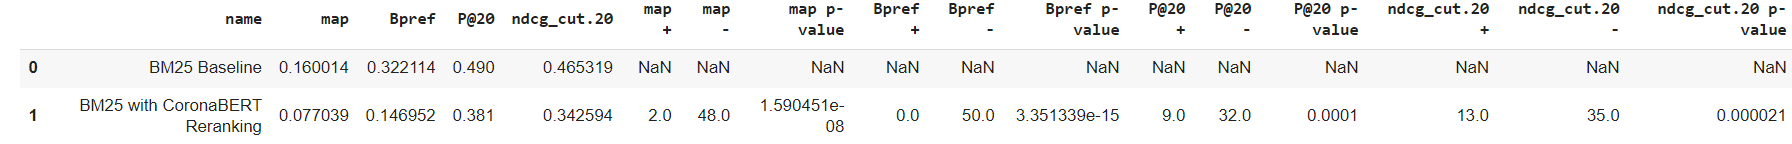